# Density Plot

In [1]:
import pandas as pd
import numpy as np

from plotnine import (
    ggplot,
    aes,
    after_stat,
    geom_density,
    geom_histogram,
    geom_vline,
    geom_rect,
    labs,
    annotate,
    theme_tufte,
)
from plotnine.data import mpg

### Density Plot

In [2]:
mpg.head()

The defaults are not exactly beautiful, but still quite clear.

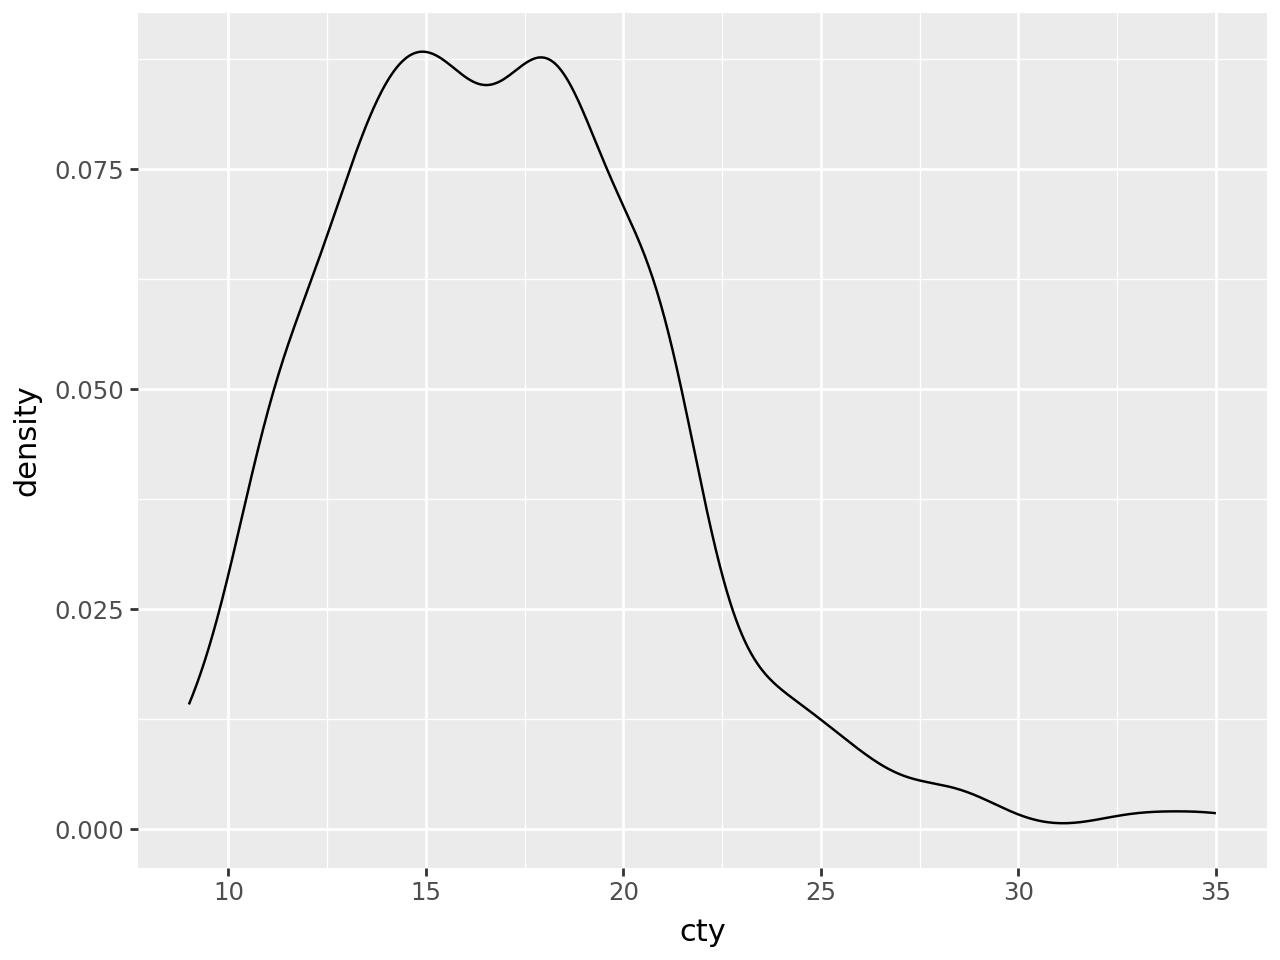

In [3]:
(
    ggplot(mpg, aes(x="cty"))
    + geom_density()
)

Plotting multiple groups is straightforward, but as each group is
plotted as an independent PDF summing to 1, the relative size of each
group will be normalized.

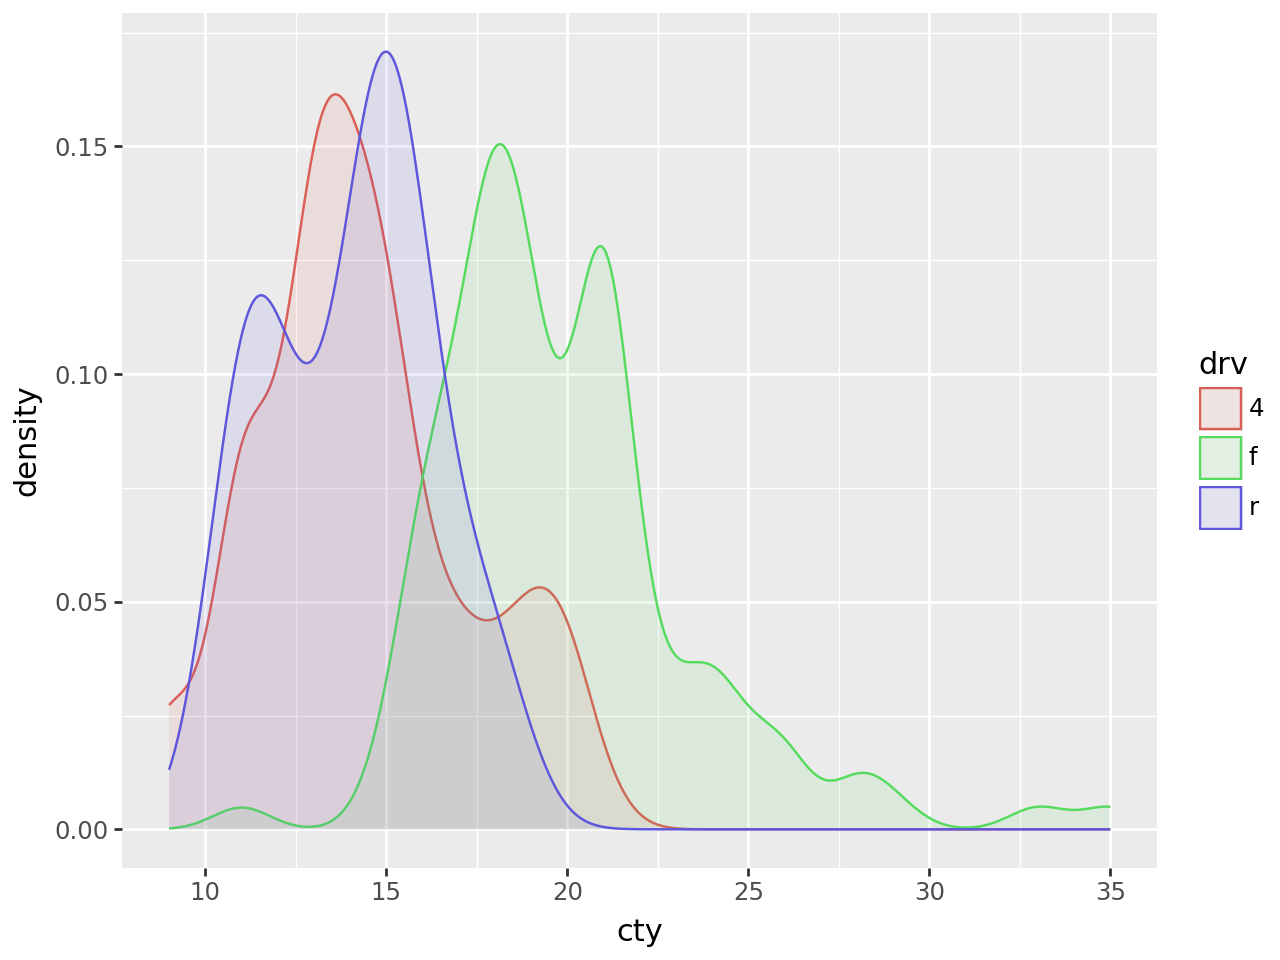

In [4]:
(
    ggplot(mpg, aes(x="cty", color="drv", fill="drv"))
    + geom_density(alpha=0.1)
)

To plot multiple groups and scale them by their relative size, you can
map the `y` aesthetic to `'count'` (calculated by `stat_density`).

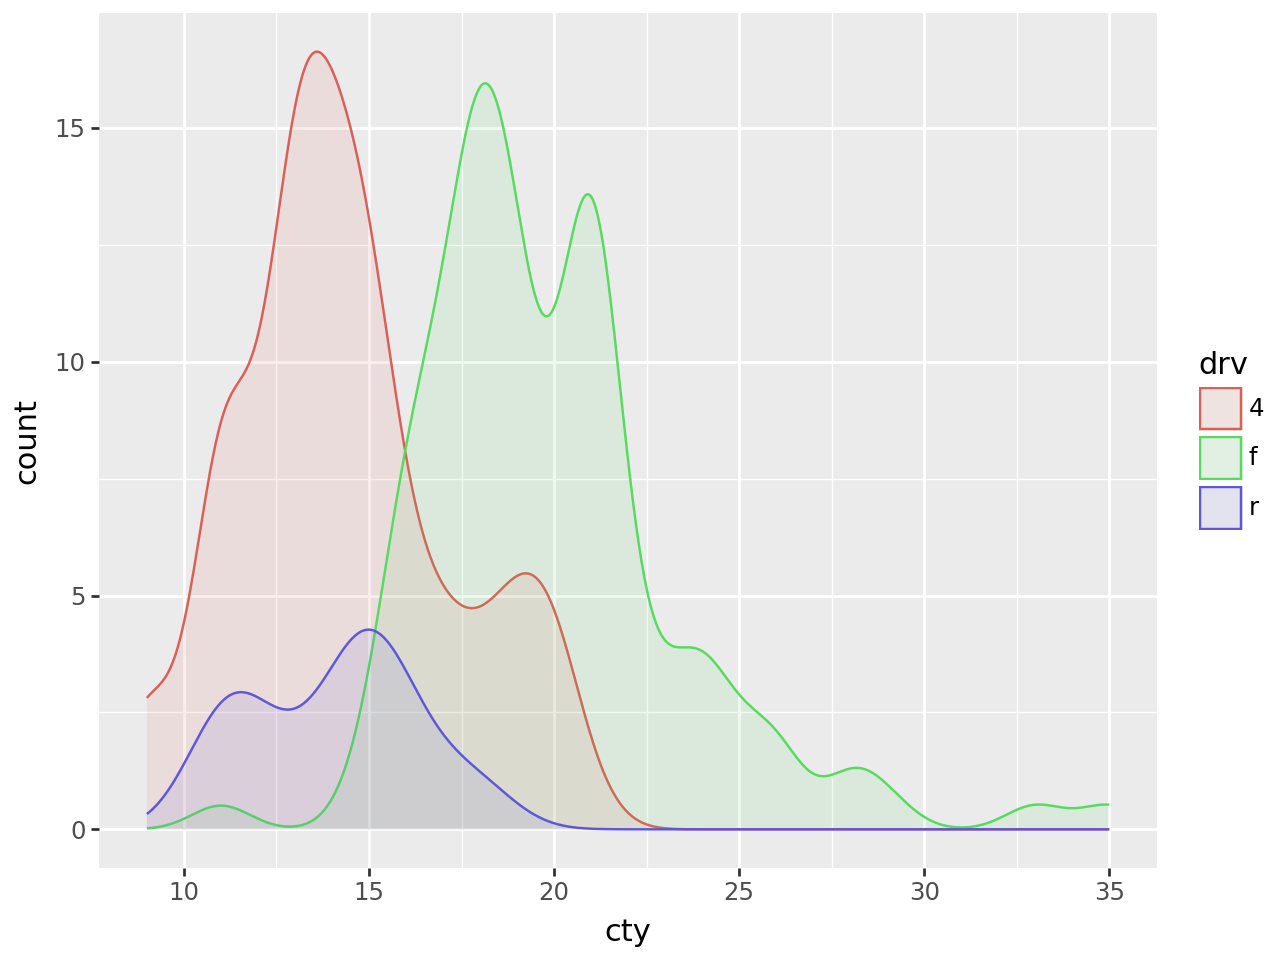

In [5]:
(
    ggplot(mpg, aes(x="cty", color="drv", fill="drv"))
    + geom_density(aes(y=after_stat("count")), alpha=0.1)
)

### Density Plot + Histogram

To overlay a histogram onto the density, the `y` aesthetic of the
density should be mapped to the `'count'` scaled by the `binwidth` of
the histograms.

**Why?**

The `count` calculated by `stat_density` is $count = density * n$ where
`n` is the number of points . The `density` curves have an area of 1 and
have no information about the absolute frequency of the values along
curve; only the relative frequencies. The `count` curve reveals the
absolute frequencies. The scale of this `count` corresponds to the
`count` calculated by the `stat_bin` for the histogram when the bins are
1 unit wide i.e. `binwidth=1`. The `count * binwidth` curve matches the
scale of `count`s for the histogram for a give `binwidth`.

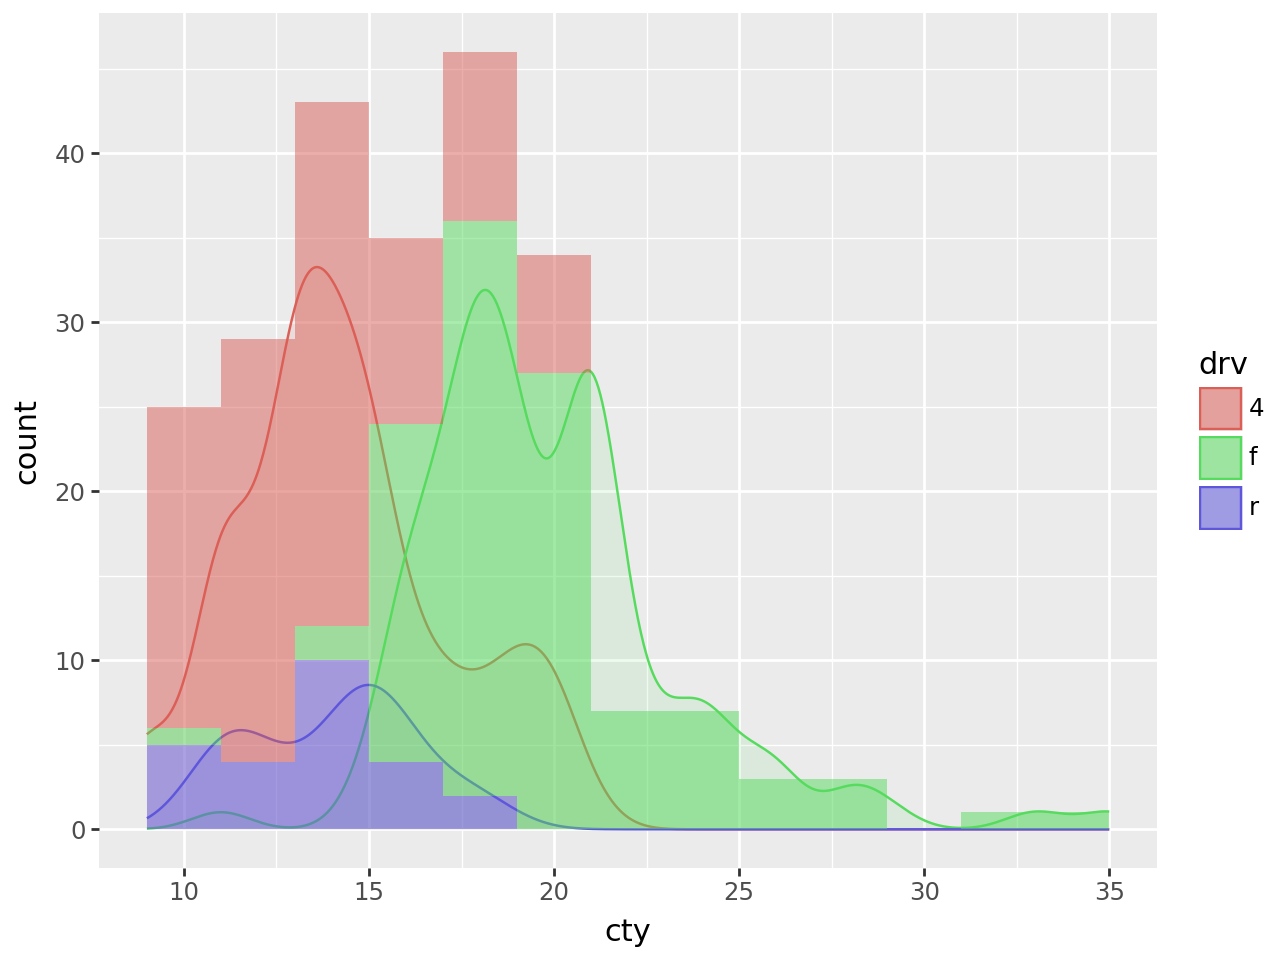

In [6]:
binwidth = 2  # The same for geom_density and geom_histogram

(
    ggplot(mpg, aes(x="cty", color="drv", fill="drv"))
    + geom_density(aes(y=after_stat("count*binwidth")), alpha=0.1)
    + geom_histogram(
        aes(fill="drv", y=after_stat("count")),
        binwidth=binwidth,
        color="none",
        alpha=0.5,
    )
    # It is the histogram that gives us the meaningful y axis label
    # i.e. 'count' and not 'count*2'
    + labs(y="count")
)

### Shading a Region under a Density Curve

*Extending geom_density to create an effect of a shaded region*

Create some data and plot the density

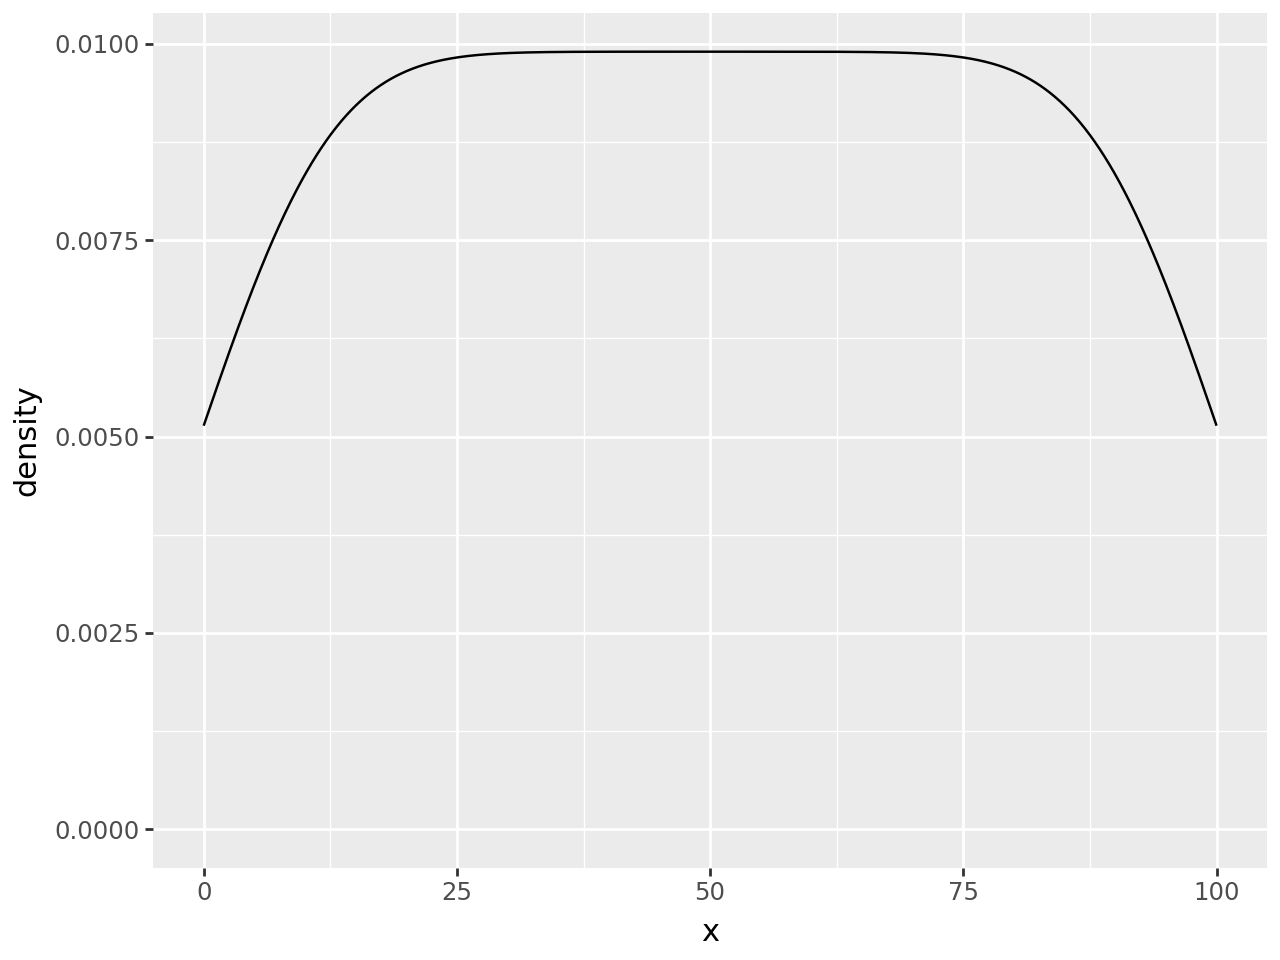

In [7]:
n = 101
df = pd.DataFrame({"x": np.arange(n)})

(
    ggplot(df, aes("x"))
    + geom_density()
)

Suppose we want to mark a region as special e.g. `(40, 60)`, we can use
vertical lines to `annotate` it.

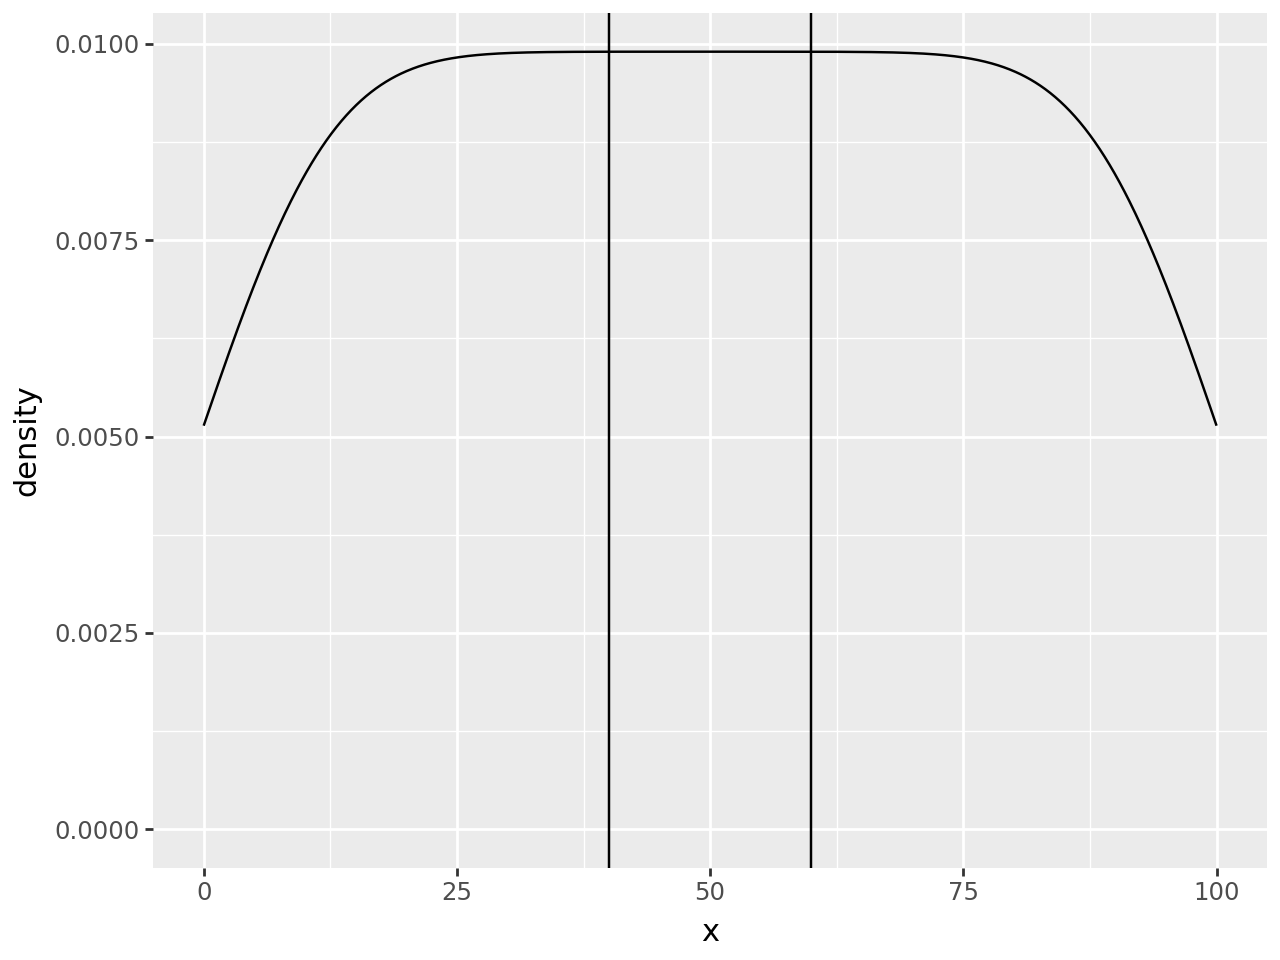

In [8]:
region = (40, 60)

(
    ggplot(df, aes("x"))
    + geom_density()
    + annotate(geom_vline, xintercept=region)  # new line
)

To make it standout more we can highlight. To do that, the first thought
is to use a rectangle.

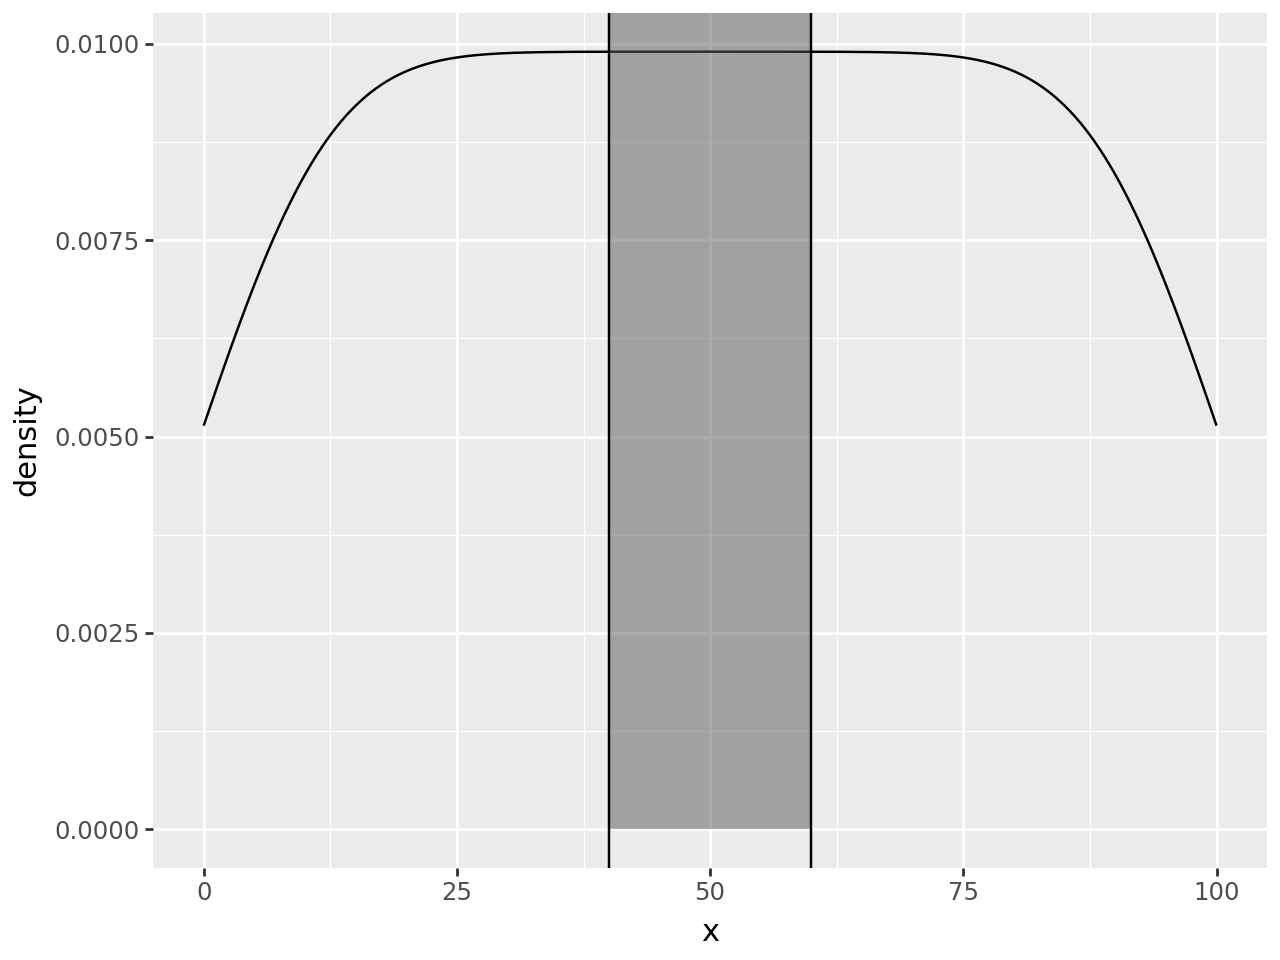

In [9]:
region = (40, 60)

(
    ggplot(df, aes("x"))
    + geom_density()
    + annotate(
        geom_rect, xmin=region[0], xmax=region[1], ymin=0, ymax=float("inf"), alpha=0.5
    )  # new annotation layer
    + annotate(geom_vline, xintercept=region)
)

Since `y` upper-bound varies along the curve, a rectangular highlight
has to stretch up to the top of the panel.

To hightlight only within the density curve, we have to use a second
density curve. We need to calculate the density as normal, but just
before the curve & region are plotted, we should keep only the region we
want.

We create our own `geom_density_highlight` and override the `setup_data`
method. First, we override but do nothing, we only inspect the data to
see what we have to work with.

      PANEL     count   density  group    n    scaled           x         y  \
0         1  0.519038  0.005139     -1  101  0.519039    0.000000  0.005139   
1         1  0.522757  0.005176     -1  101  0.522758    0.097752  0.005176   
2         1  0.526473  0.005213     -1  101  0.526474    0.195503  0.005213   
3         1  0.530187  0.005249     -1  101  0.530188    0.293255  0.005249   
4         1  0.533899  0.005286     -1  101  0.533900    0.391007  0.005286   
...     ...       ...       ...    ...  ...       ...         ...       ...   
1019      1  0.533899  0.005286     -1  101  0.533900   99.608993  0.005286   
1020      1  0.530187  0.005249     -1  101  0.530188   99.706745  0.005249   
1021      1  0.526473  0.005213     -1  101  0.526474   99.804497  0.005213   
1022      1  0.522757  0.005176     -1  101  0.522758   99.902248  0.005176   
1023      1  0.519038  0.005139     -1  101  0.519039  100.000000  0.005139   

      ymin      ymax  
0        0  0.005139  
1    

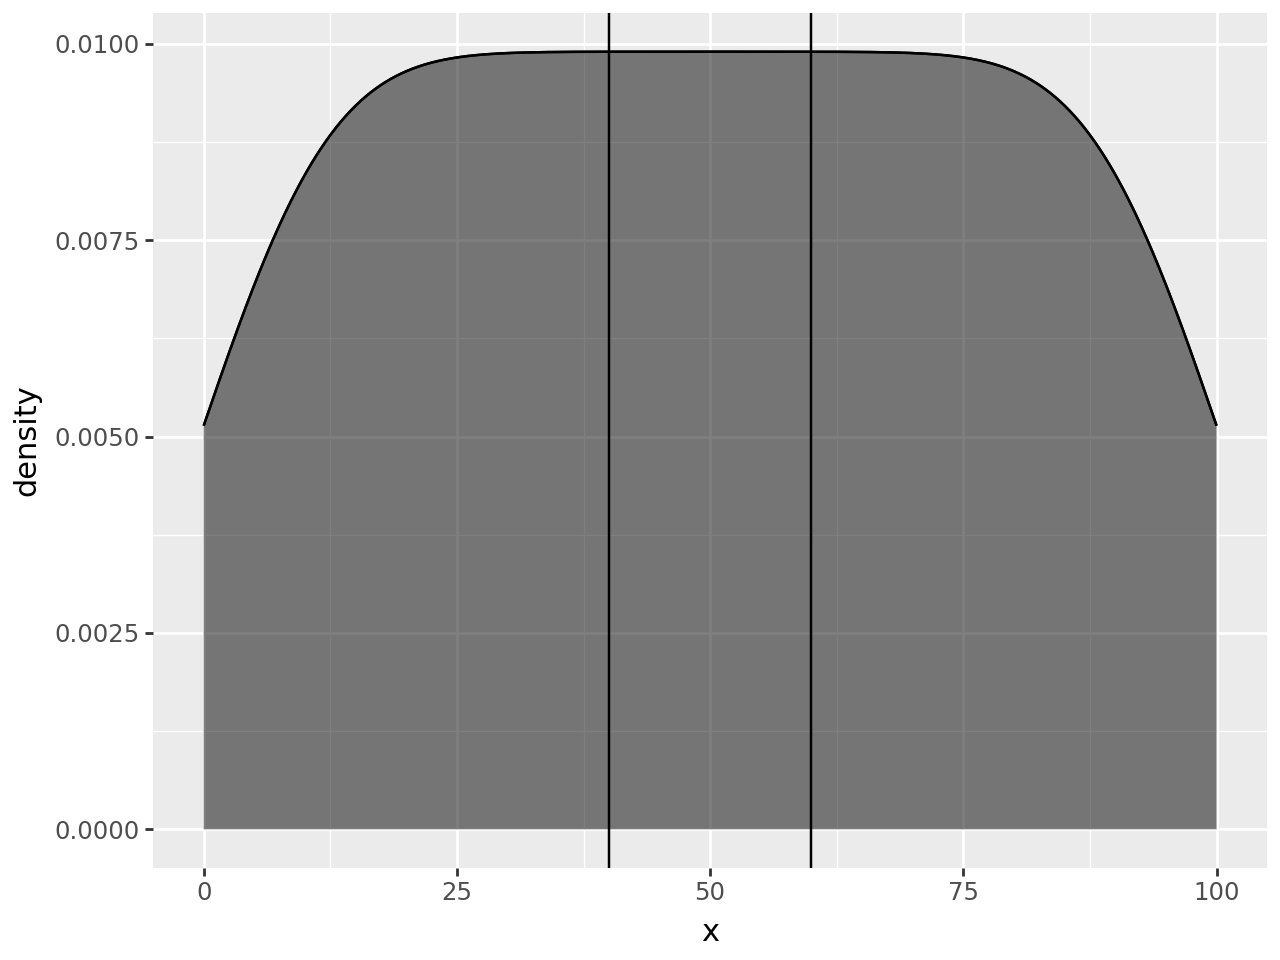

In [10]:
# new class
class geom_density_highlight(geom_density):
    def setup_data(self, data):
        data = super().setup_data(data)
        print(data)
        return data


region = (40, 60)

(
    ggplot(df, aes("x"))
    + geom_density()
    + geom_density_highlight(fill="black", alpha=0.5)  # new line
    + annotate(geom_vline, xintercept=region)
)

The highlight has filled the whole region, but the printed data suggests
that we can limit the rows to those where `x` column is within our
region.

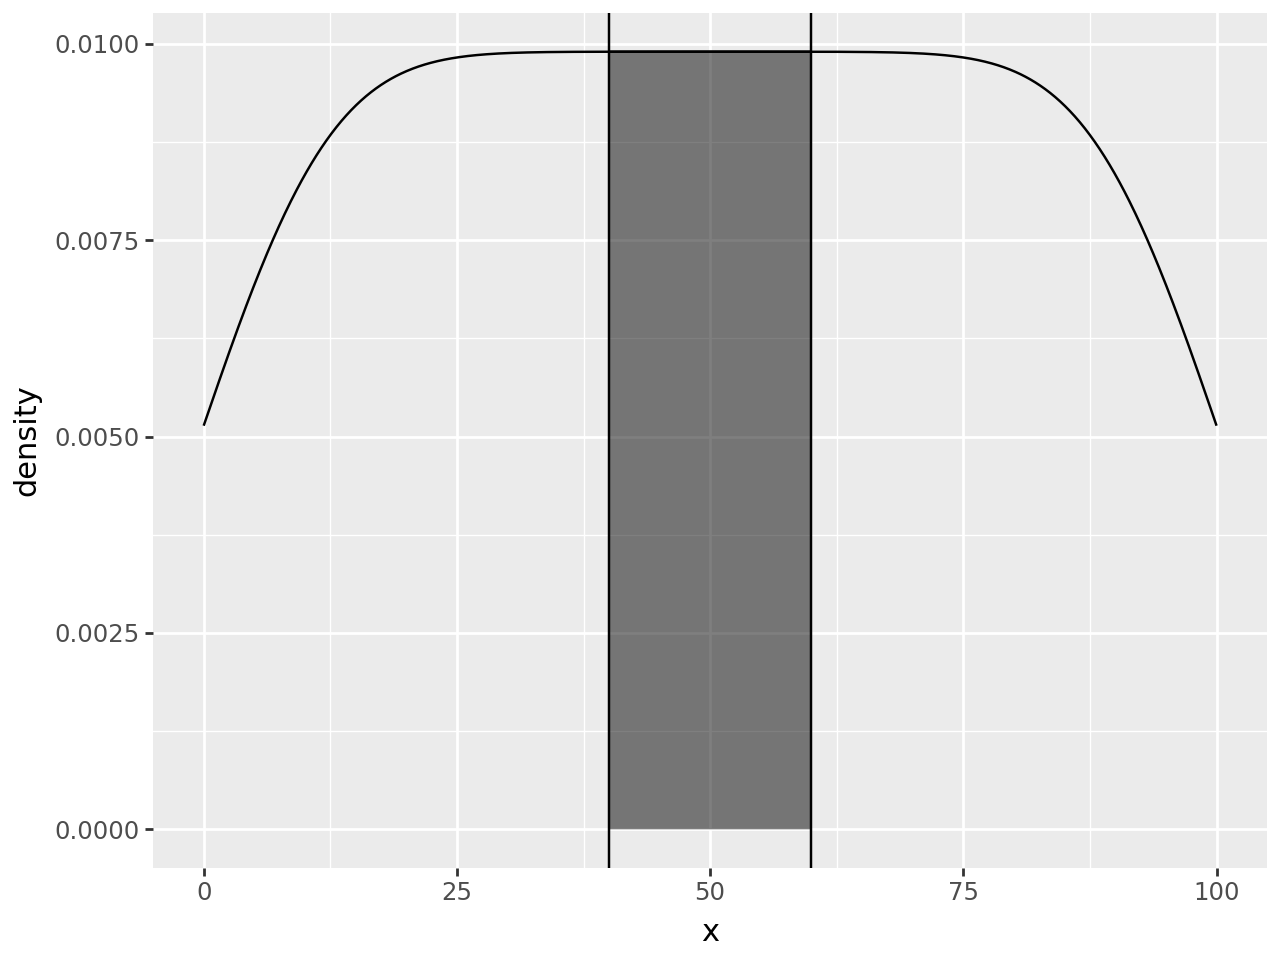

In [11]:
class geom_density_highlight(geom_density):
    # new method
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f"{self.region[0]} <= x <= {self.region[1]}"  # new line
        data = data.query(s).reset_index(drop=True)  # new line
        return data


region = (40, 60)

(
    ggplot(df, aes("x"))
    + geom_density()
    + geom_density_highlight(region=region, fill="black", alpha=0.5)  # modified line
    + annotate(geom_vline, xintercept=region)
)

That is it, but we can make it look better.

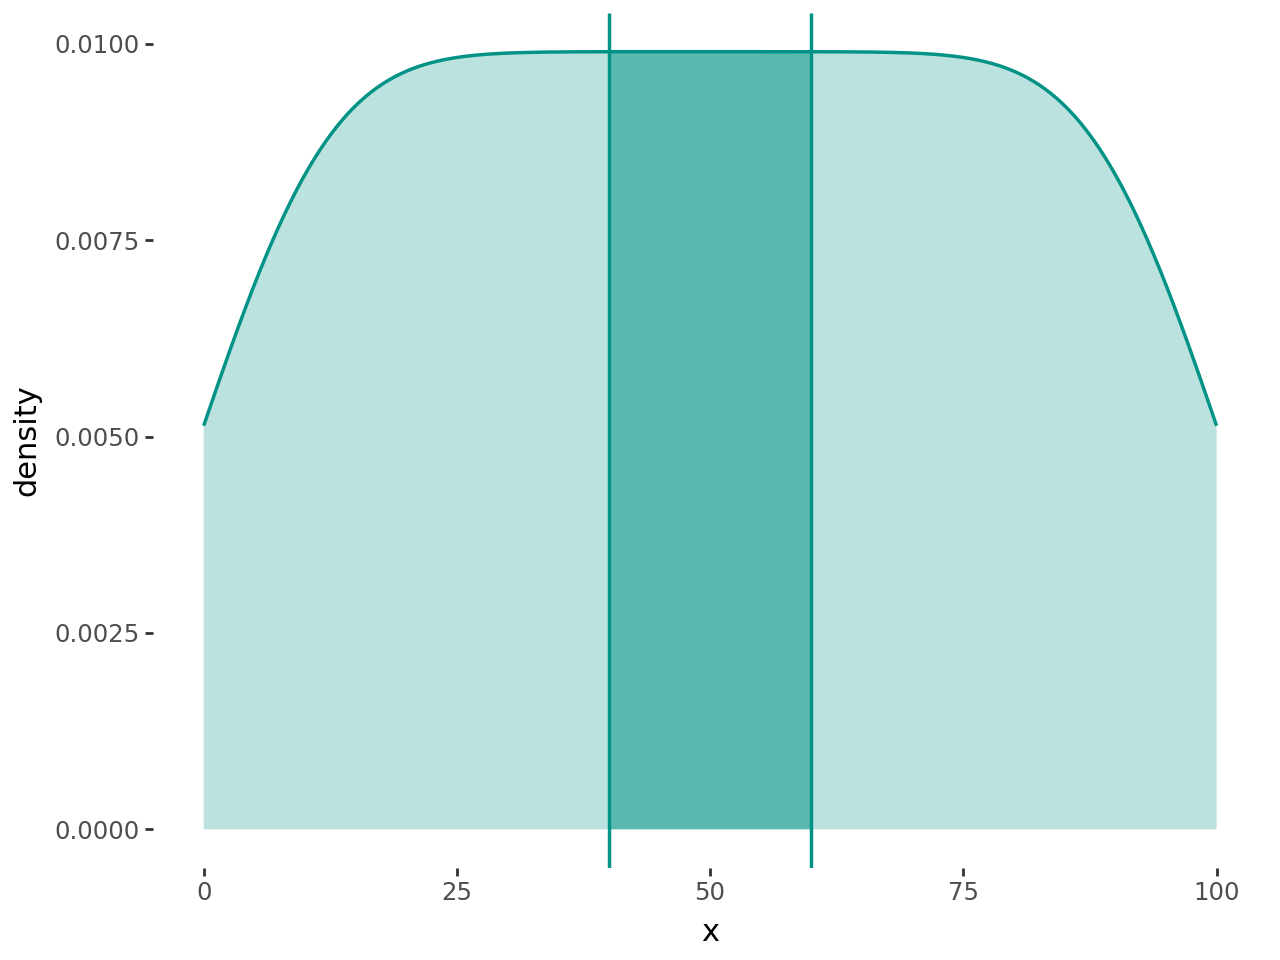

In [12]:
class geom_density_highlight(geom_density):
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f"{self.region[0]} <= x <= {self.region[1]}"
        data = data.query(s).reset_index(drop=True)
        return data


region = (40, 60)
teal = "#029386"

# Gallery Plot

(
    ggplot(df, aes("x"))
    + geom_density_highlight(region=region, fill=teal + "88", color="none")
    + geom_density(fill=teal + "44", color=teal, size=0.7)
    + annotate(geom_vline, xintercept=region, color=teal, size=0.7)
    + theme_tufte()
)

This example was motivated by a
[question](https://github.com/has2k1/plotnine/issues/574) from github
user [Rishika-Ravindran](https://github.com/Rishika-Ravindran).